In [1]:
import os 
from math import sqrt
from numpy import concatenate
from numpy import subtract
from numpy import delete
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import RNN
from keras.layers import SimpleRNN
from math import floor
from scipy.stats import linregress
import numpy as np
import keras.layers

C:\Users\shangoba\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
dataset = read_csv('sp500Price.csv', header=0, index_col=None)

In [9]:
def rnnPredict(inputTimeSeries, n_days_lagged = 4):
    n_days_lagged = 4
    #def rnnPredict(timeSeriesInput, n_days_lagged = 4):
    values = inputTimeSeries.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    #frame as supervised learning using lagged inputs
    reframed = series_to_supervised(scaled, n_days_lagged, 1)
    n_features = values.shape[1]
    print(reframed.shape)
    
    
    # split  data into train and test sets
    values = reframed.values
    n_train_days = int(floor(values.shape[0]*0.75))
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    
    # split data into input and outputs
    # inputs are fixed sliding window of stock prices
    # outputs are one day ahead stock prices
    n_obs = n_days_lagged * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days_lagged, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days_lagged, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # design and fit network #####################################################
    model = Sequential()
    model.add(GRU(200, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(BatchNormalization())
    #model.add(Activation("tanh"))
    model.add(Dropout(0.3))
    model.add(GRU(200, return_sequences=True))
    #model.add(BatchNormalization())
    #model.add(Activation("tanh"))
    model.add(Dropout(0.3))
    model.add(GRU(200))
    #model.add(BatchNormalization())
    #model.add(Activation("tanh"))
    #model.add(ActivityRegularization(l1=0.05, l2=0.03))
    model.add(Dense(1))
    #model.compile(loss='mean_absolute_percentage_error', optimizer='Adam')
    model.compile(loss='mean_absolute_percentage_error', optimizer='Adam')
    
    # fitting the network
    history = model.fit(train_X, train_y, epochs=20, batch_size=500, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    
    ############################################################
    # plot training information: loss and validation loss
    pyplot.figure(1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.suptitle("Training and validation loss")
    pyplot.ylabel("MAPE (mean absolute percent error)")
    pyplot.xlabel("number of epochs")
    pyplot.legend()
    pyplot.show()
    print(history.history)
    
    #score = model.evaluate(test_X, test_y, batch_size=16)
    #######################################################################
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days_lagged*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    pyplot.figure(2)
    #pyplot.subplot(211)
    
    pyplot.plot(inv_y, label='true prices')
    pyplot.plot(inv_yhat, label='forecasted prices')
    pyplot.suptitle("Test set actual vs forecast")
    pyplot.ylabel("Prices")
    pyplot.xlabel("Days")
    #pyplot.text("MAPE: " + str(mean_absolute_percentage_error(inv_y, inv_yhat)), fontsize = 15,
    #            horizontalalignment='center', verticalalignment = "center")
    t = pyplot.text(floor(len(inv_y)/2), floor(inv_y[1]), "MAPE: " + "{0:.2f}".format(mean_absolute_percentage_error(inv_y, inv_yhat)), fontsize=15)
    t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
    pyplot.legend()
    pyplot.show()
    
    #mean_absolute_error(inv_y, inv_yhat)
    mean_absolute_percentage_error(inv_y, inv_yhat)



(2823, 5)
(2117, 4) 2117 (2117,)
(2117, 4, 1) (2117,) (706, 4, 1) (706,)
Train on 2117 samples, validate on 706 samples
Epoch 1/20
2117/2117 [==============================] - 8s 4ms/step - loss: 237.0401 - val_loss: 55.9989
Epoch 2/20
2117/2117 [==============================] - 4s 2ms/step - loss: 120.6586 - val_loss: 37.1692
Epoch 3/20
2117/2117 [==============================] - 3s 1ms/step - loss: 61.1182 - val_loss: 8.0884
Epoch 4/20
2117/2117 [==============================] - 3s 1ms/step - loss: 75.4810 - val_loss: 4.7053
Epoch 5/20
2117/2117 [==============================] - 3s 1ms/step - loss: 59.3700 - val_loss: 19.9425
Epoch 6/20
2117/2117 [==============================] - 3s 1ms/step - loss: 52.4599 - val_loss: 6.7392
Epoch 7/20
2117/2117 [==============================] - 3s 1ms/step - loss: 52.2705 - val_loss: 4.4028
Epoch 8/20
2117/2117 [==============================] - 3s 2ms/step - loss: 56.8869 - val_loss: 18.8672
Epoch 9/20
2117/2117 [============================

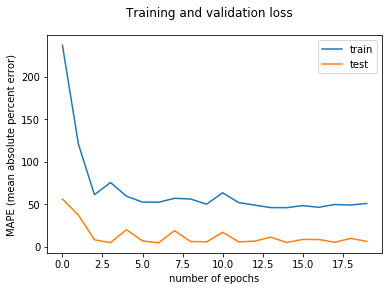

{'val_loss': [55.9989375041497, 37.16918951796405, 8.088387504177796, 4.705298107676736, 19.942487803126866, 6.739210254409834, 4.402835785836066, 18.867236702030173, 6.111231521574026, 5.555117408547118, 16.925663907534677, 5.646240291109166, 6.48080997358976, 11.199994935530103, 4.917954192283133, 8.501681258928336, 8.446840197101194, 5.148441282277743, 9.780203667983793, 6.14297758080804], 'loss': [237.0400594730224, 120.65863275325236, 61.118201523836234, 75.48099885146799, 59.369952933879524, 52.45987705019886, 52.270503108322366, 56.88693367224231, 56.07701652816967, 49.969005987449364, 63.39641880797619, 51.88240373230341, 48.87030392229191, 45.96129906509753, 45.887849572136204, 48.27625028153439, 46.321875641579105, 49.59928683374195, 49.01172373865818, 50.8187511436884]}


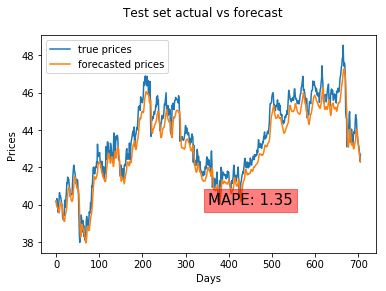

In [15]:
rnnPredict(dataset)

For the last 700 days of unseen test data, given 4 days of previous index values and forecasting one day ahead index values, MAPE (mean absolute percentage error) is about 1 percent. 

Just as an experiment, we decompose the input time series into it's intrinsic mode functions by Emprical Mode Decomposition (EMD). EMD is similar to Fourier Transform but it is better suited for nonstationary and nonlinear data.

Below you can see an example of how the input time series is decomposed:

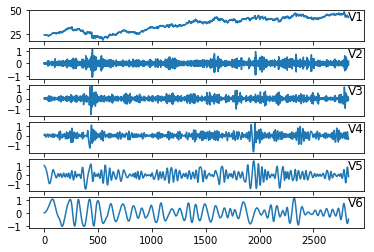

In [16]:
dataset = read_csv('sp500Price_EMD.csv', header=0, index_col=None)
values = dataset.values
# specify columns to plot

groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()



Recurrent Neural Networks tend to work better when the inputs are scaled and normalized as it was in the first case shown above. Emprical mode decomposition turns the input time series into a multiple signals which are scaled and normalized. This time the input is a lagged fixed length window of intrinsic mode functions of the original signal. Let's see whether applying EMD to the original input signal improves the forecast performance. 

(2823, 40)
(2117, 32) 2117 (2117,)
(2117, 4, 8) (2117,) (706, 4, 8) (706,)
Train on 2117 samples, validate on 706 samples
Epoch 1/20
2117/2117 [==============================] - 12s 6ms/step - loss: 290.5421 - val_loss: 66.5367
Epoch 2/20
2117/2117 [==============================] - 3s 1ms/step - loss: 376.3521 - val_loss: 62.3476
Epoch 3/20
2117/2117 [==============================] - 3s 1ms/step - loss: 120.5897 - val_loss: 69.7301
Epoch 4/20
2117/2117 [==============================] - 3s 1ms/step - loss: 191.6837 - val_loss: 72.3612
Epoch 5/20
2117/2117 [==============================] - 3s 1ms/step - loss: 135.8503 - val_loss: 71.1050
Epoch 6/20
2117/2117 [==============================] - 3s 1ms/step - loss: 121.0954 - val_loss: 63.4073
Epoch 7/20
2117/2117 [==============================] - 3s 1ms/step - loss: 111.0055 - val_loss: 55.1705
Epoch 8/20
2117/2117 [==============================] - 3s 1ms/step - loss: 113.4266 - val_loss: 44.2976
Epoch 9/20
2117/2117 [===============

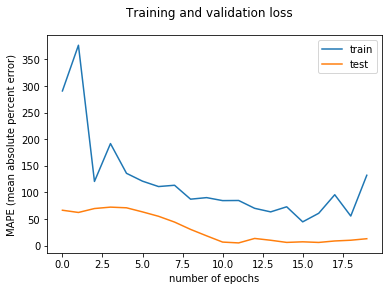

{'val_loss': [66.53665522070175, 62.34760174197448, 69.73012752370862, 72.36115005536391, 71.10504947910903, 63.407284885222786, 55.17047937193268, 44.29757462412372, 30.548737939288866, 18.459337866677778, 6.733322643355675, 5.162077752456449, 13.560977192843602, 10.160631802534585, 6.117778625434249, 7.223414855368077, 6.063129442609403, 8.812555330670927, 10.218293561476148, 13.046880592367804], 'loss': [290.5420601601076, 376.35212379387093, 120.58965662261141, 191.68365866292126, 135.8502511631277, 121.0954084905409, 111.0054661386352, 113.42655309461793, 87.2990148865957, 90.21812778629669, 84.60531389527463, 84.83842070214186, 70.12805778438549, 63.44543124213779, 73.0040003907641, 44.73052922340288, 60.82114297283895, 95.67010430564393, 55.6267059629798, 132.19256018105688]}


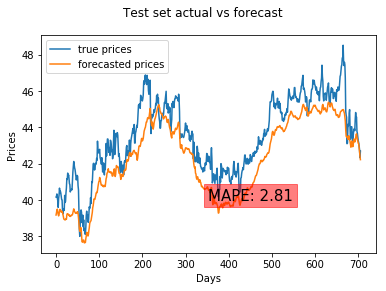

In [17]:
rnnPredict(dataset)

Based on MAPE, Emprical Mode Decomposition worsened the forecasting performance of an RNN. 